# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow.keras
#from tensorflow.keras.datasets import mnist
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.regularizers import l1, l2, l1_l2

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Data

What are the relevant label and feature columns?

In [2]:
# WHAT'S THE LABEL COLUMN
# WHAT'S THE TEXT COLUMN
tweets_df = pd.read_csv('C:/Users/casey/OneDrive/Documents/Data_Science/Projects/Movie_Review_Sentiment_Analysis/data/Corona_tweets.csv', encoding='latin1')
tweets_df.head()

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   

                                       OriginalTweet           Sentiment  
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1  When I couldn't find hand sanitizer at Fred Me...            Positive  
2  Find out how you can protect yourself and love...  Extremely Positive  
3  #Panic buying hits #NewYork City as anxious sh...            Negative  
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral

# EDA

Get num rows and columns and column names

In [3]:
print('There are ', tweets_df.shape[0], ' rows.')
print('There are ', tweets_df.shape[1], ' columns.')
print('Column Names: ', tweets_df.columns)
print('Column Types: ', tweets_df.dtypes)

There are  44955  rows.
There are  6  columns.
Column Names:  Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
Column Types:  UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object


Check for missing values in relevant features or labels

In [4]:
## CHECK FOR MISSING VALUES
tweets_df.info() # there are no missing values in the Sentiment or OriginalTweet columns which is what we care about

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


Check for weird values in label column

In [5]:
# There does appear to be a label imbalance, may have to address it
# There are also labels that should be combined. Extremely Positive -> P
# ositive, Extremely Negative -> Negative
tweets_df['Sentiment'].value_counts()

Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: count, dtype: int64

In [6]:
## COMBINE THE LABELS
# Define a mapping dictionary
label_mapping = {
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
}

# Use .map() with the mapping dictionary, and fill missing values (for values not in the mapping)
# Values that don’t have a corresponding entry in the dictionary ('positive', 'neutral', etc.) will be turned into NaN. fillna(df['sentiment']) ensures that any unmapped values remain unchanged.
tweets_df['Sentiment'] = tweets_df['Sentiment'].map(label_mapping).fillna(tweets_df['Sentiment'])

In [7]:
## CHECK FOR MISSING VALUES
tweets_df.info() # there are no missing values in the Sentiment or OriginalTweet columns which is what we care about

## LOOK AT LABEL BALANCE

tweets_df['Sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


Sentiment
Positive    19592
Negative    17031
Neutral      8332
Name: count, dtype: int64

## Label Balance
### If Imbalanced
* Random Undersampling
* Class weights

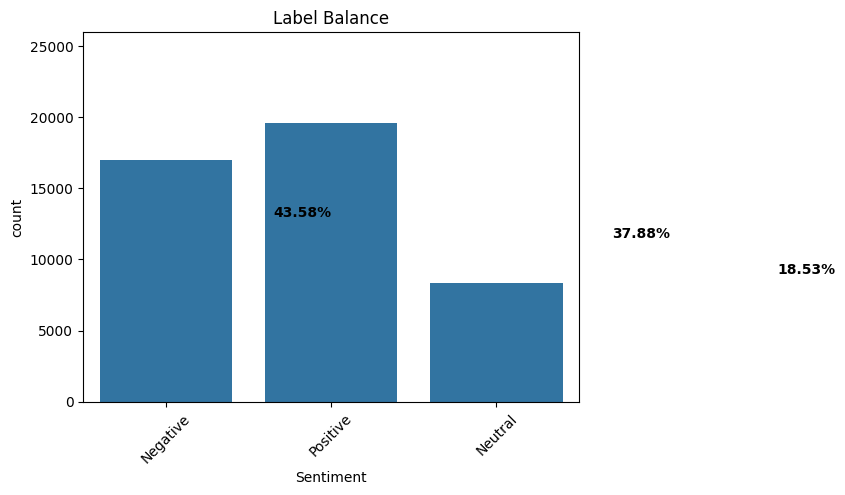

Positive percent is: 43.58
Negative percent is: 37.88
Neutral percent is: 18.53


In [9]:
# # percent of labels equal to 'Positive'
# positive_percent = round(tweets_df['Sentiment'].value_counts().iloc[0] / len(tweets_df.index) * 100, 2)

# # percent of labels equal to 'Negative'
# negative_percent = round(tweets_df['Sentiment'].value_counts().iloc[1] / len(tweets_df.index) * 100, 2)

# # percent of labels equal to 'Neutral'
# neutral_percent = round(tweets_df['Sentiment'].value_counts().iloc[2] / len(tweets_df.index) * 100, 2)

 
# sns.countplot(data=tweets_df, x='Sentiment')
# plt.ylim(0, 26000)
# plt.text(0.65, 13000, str(positive_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(2.7, 11500, str(negative_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(3.7, 9000, str(neutral_percent) + '%', size='medium', color='black', weight='semibold')
# plt.title('Label Balance')
# plt.xticks(rotation=45)
# plt.show()

# print("Positive percent is: " + str(positive_percent))
# print("Negative percent is: " + str(negative_percent))
# print("Neutral percent is: " + str(neutral_percent))

sns.countplot(data=tweets_df, x='Exited')
# plt.ylim(0, 26000)
# plt.text(0.65, 13000, str(positive_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(2.7, 11500, str(negative_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(3.7, 9000, str(neutral_percent) + '%', size='medium', color='black', weight='semibold')
plt.title('Label Balance')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Label percentages
label_counts = tweets_df['Seniment'].value_counts()
label_percentages = (label_counts / len(tweets_df)) * 100

# Print label counts and percentages
print("Label Counts:")
print(label_counts)
print("\nLabel Percentages (%):")
print(label_percentages)

Check for weird tweets to omit
* super short
* super long

In [10]:
# sort ascending by tweet length
# may want to omit really short tweets # tweets_df[tweets_df['OriginalTweet'].str.len() > 20]
tweets_df['OriginalTweet'].str.len().sort_values()#[:20]

24265     11
13574     11
39324     11
20670     11
19375     12
        ... 
236      349
4000     349
11281    360
28958    365
3001     378
Name: OriginalTweet, Length: 44955, dtype: int64

In [ ]:
tweets_df.loc[23345].OriginalTweet

'An American living in  '

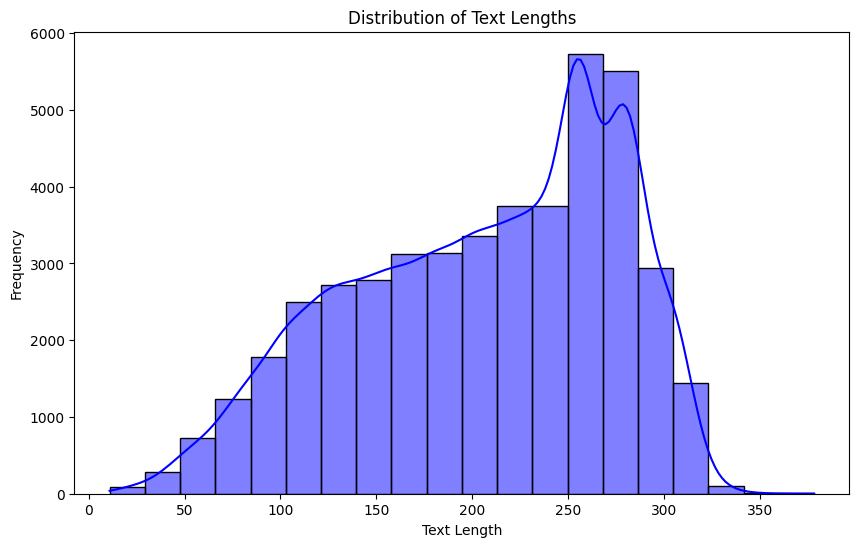

In [12]:
## Use for max_sequence length
tweets_df['tweet_length'] = tweets_df['OriginalTweet'].str.len()

# Plot the distribution of text lengths using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(tweets_df['tweet_length'], bins=20, kde=True, color='blue')  # KDE adds a smooth curve
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

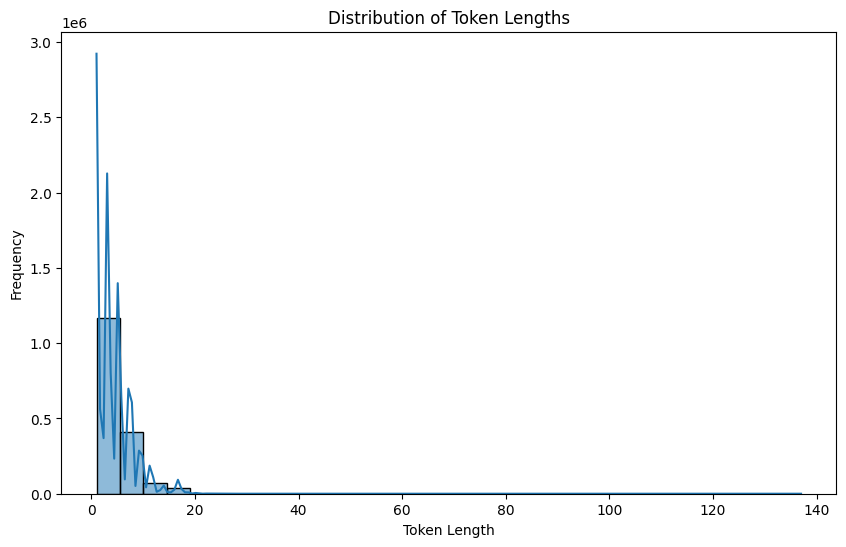

In [6]:
# Tokenize function (as provided)
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

# Apply tokenization to the 'OriginalTweet' column
tweets_df['tokenized_text'] = tweets_df['OriginalTweet'].apply(tokenize)

# Flatten the tokenized lists into a single list
all_tokens = [token for sublist in tweets_df['tokenized_text'] for token in sublist]

# Get the length of each token
token_lengths = [len(token) for token in all_tokens]

# Plot the distribution of token lengths using seaborn or matplotlib
plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
token_df = pd.DataFrame()
token_df['token_lengths'] = token_lengths
token_df['token_lengths'].max()

137

Check if there are odd characters that should be eliminated

In [10]:
all_tokens = [token for sublist in tweets_df['tokenized_text'] for token in sublist]

# Print the first 10 tokens (optional, for checking)
print(all_tokens[:10])

# Get the total number of tokens
print(f'Total number of tokens: {len(all_tokens)}')

# To get unique tokens, use set
unique_tokens = set(all_tokens)
print(f'Number of unique tokens: {len(unique_tokens)}')

['TRENDING', ':', 'New', 'Yorkers', 'encounter', 'empty', 'supermarket', 'shelves', '(', 'pictured']
Total number of tokens: 1691760
Number of unique tokens: 107026


In [14]:
df = pd.DataFrame()
df['tokens'] = all_tokens
df[df['tokens'].str.len() < 3]

tokens
1            :
8            (
10           ,
12          in
14           )
...        ...
1691748     it
1691749     's
1691755      .
1691756     Up
1691757     to

[537985 rows x 1 columns]

# Pre-Processing

* Label Mapping if necessary
* Train Test Val Split
* Custom Normalization on text if necessary
* Random Undersampling if necessary
* Tokenization and Vectorization of Text (text vectorization layer)
* Adapt vocabulary on training set
* Convert to Tensors

In [53]:
## LOAD DATA
tweets_df = pd.read_csv('C:/Users/casey/OneDrive/Documents/Data_Science/Projects/Movie_Review_Sentiment_Analysis/data/Corona_tweets.csv', encoding='latin1')

Label Mapping

In [54]:
# Define a mapping dictionary
label_mapping = {
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
}

# Use .map() with the mapping dictionary, and fill missing values (for values not in the mapping)
# Values that don’t have a corresponding entry in the dictionary ('positive', 'neutral', etc.) will be turned into NaN. fillna(df['sentiment']) ensures that any unmapped values remain unchanged.
tweets_df['Sentiment'] = tweets_df['Sentiment'].map(label_mapping).fillna(tweets_df['Sentiment'])

label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

tweets_df['Sentiment'] = tweets_df['Sentiment'].map(label_mapping_int).fillna(tweets_df['Sentiment'])

print(tweets_df.Sentiment.value_counts())

Sentiment
0    19592
1    17031
2     8332
Name: count, dtype: int64


Select label and text columns

In [76]:
X = tweets_df.OriginalTweet
y = tweets_df.Sentiment

Train_test_split
* If there is label imbalance ensure stratify is used

In [56]:
twenty_percent_size = round(len(X) * 0.2)
print(twenty_percent_size)

8991


In [57]:
## Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=twenty_percent_size, random_state=1, stratify=y)

## Create validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=twenty_percent_size, random_state=1, stratify=y_train)


## Set the input shape
train_input_shape=X_train.shape
test_input_shape=X_test.shape
val_input_shape=X_val.shape

# check shapes
print("The input shape for the training reviews is\n", train_input_shape) ## (30000)
print("The input shape for the testing reviews is\n", test_input_shape) ## (5000)
print("The input shape for the validation reviews is\n",val_input_shape) ## (5000)

The input shape for the training reviews is
 (26973,)
The input shape for the testing reviews is
 (8991,)
The input shape for the validation reviews is
 (8991,)


In [58]:
# Print percentage of each label in the training set
train_label_counts = np.bincount(y_train)
train_label_percentages = train_label_counts / len(y_train) * 100

print("Training Set Label Percentages:")
for label, percentage in enumerate(train_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")

print("\nTraining Set Label Value Counts:")
print(y_train.value_counts())

# Print percentage of each label in the testing set
test_label_counts = np.bincount(y_test)
test_label_percentages = test_label_counts / len(y_test) * 100

print("\nTesting Set Label Percentages:")
for label, percentage in enumerate(test_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")

print("\nTesting Set Label Value Counts:")
print(y_test.value_counts())

# Print percentage of each label in the validation set
val_label_counts = np.bincount(y_val)
val_label_percentages = test_label_counts / len(y_val) * 100

print("\nValidation Set Label Percentages:")
for label, percentage in enumerate(val_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")

print("\nValidation Set Label Value Counts:")
print(y_val.value_counts())

Training Set Label Percentages:
Label 0: 43.58%
Label 1: 37.89%
Label 2: 18.53%

Training Set Label Value Counts:
Sentiment
0    11755
1    10219
2     4999
Name: count, dtype: int64

Testing Set Label Percentages:
Label 0: 43.58%
Label 1: 37.88%
Label 2: 18.54%

Testing Set Label Value Counts:
Sentiment
0    3918
1    3406
2    1667
Name: count, dtype: int64

Validation Set Label Percentages:
Label 0: 43.58%
Label 1: 37.88%
Label 2: 18.54%

Validation Set Label Value Counts:
Sentiment
0    3919
1    3406
2    1666
Name: count, dtype: int64


Random Undersampling if necessary

In [ ]:
train_df = X_train.copy()
train_df['train_labels'] = y_train

X = train_df.drop(columns=['train_labels'], axis=1) # Features
y = train_df['train_labels']  # Target/Labels

# Before undersampling
print('Original dataset class distribution:', Counter(y))

# Create the RandomUnderSampler object
rus = RandomUnderSampler(random_state=42) # can specify ratio you want as well

# Perform undersampling
X_res, y_res = rus.fit_resample(X, y)

# After undersampling
print('Resampled dataset class distribution:', Counter(y_res))
# Print percentage of each label in the testing set
test_label_counts = np.bincount(y_test)
test_label_percentages = test_label_counts / len(y_test) * 100

print("\nTesting Set Label Percentages:")
for label, percentage in enumerate(test_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")

# Convert the resampled dataset back to DataFrame if needed
train_df_resampled = pd.DataFrame(X_res, columns=X.columns)
train_df_resampled['train_labels'] = y_res
print(train_df_resampled)

X_train = train_df_resampled.drop(columns=['train_labels'], axis=1) # Features
y_train = train_df_resampled['train_labels']

Custom Normalization

In [59]:
# Twitter Specific Cleaning
def remove_hyperlinks(text):
    return re.sub(r'https?:\/\/.*[\r\n]*', ' ', text)

def remove_hashtag_symbol(text):
    return re.sub(r'#', ' ', text)

def remove_retweet_text(text):
    return re.sub(r'^RT[\s]+', ' ', text)

In [60]:
# ---------------------------------------------------------------------------------------------------------------------------- #
## CUSTOM NORMALIZATION FUNCTION

# choose which preprocessing functions to use
# not using lemmatization or stemming since using a neural network
def custom_normalization(reviews):
    reviews = reviews.apply(remove_hyperlinks)
    reviews = reviews.apply(remove_hashtag_symbol)
    reviews = reviews.apply(remove_retweet_text)
    return reviews


# ---------------------------------------------------------------------------------------------------------------------------- #
## NORMALIZE FOR MODEL

# normalize reviews
X_train = custom_normalization(X_train)
X_test = custom_normalization(X_test)
X_val = custom_normalization(X_val)

Check for number of tokens
* Use to help determine vocab size

In [61]:
def tokenize(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    return tokens

X_train_df = pd.DataFrame()
X_train_df['text'] = X_train

X_train_df['tokenized_text'] = X_train_df['text'].apply(tokenize)

# Flatten the tokenized lists into a single list
all_tokens = [token for sublist in X_train_df['tokenized_text'] for token in sublist]

# Get the length of each token
token_lengths = [len(token) for token in all_tokens]

# Print the first 10 tokens (optional, for checking)
print(all_tokens[:10])

# Get the total number of tokens
print(f'Total number of tokens: {len(all_tokens)}')

# To get unique tokens, use set
unique_tokens = set(all_tokens)
print(f'Number of unique tokens: {len(unique_tokens)}')

['Consumer', 'credit-reporting', 'protections', 'are', 'part', 'of', 'Congress', 'stimulus', 'bill', '.']
Total number of tokens: 905127
Number of unique tokens: 57865


Check lengths to help determine max length

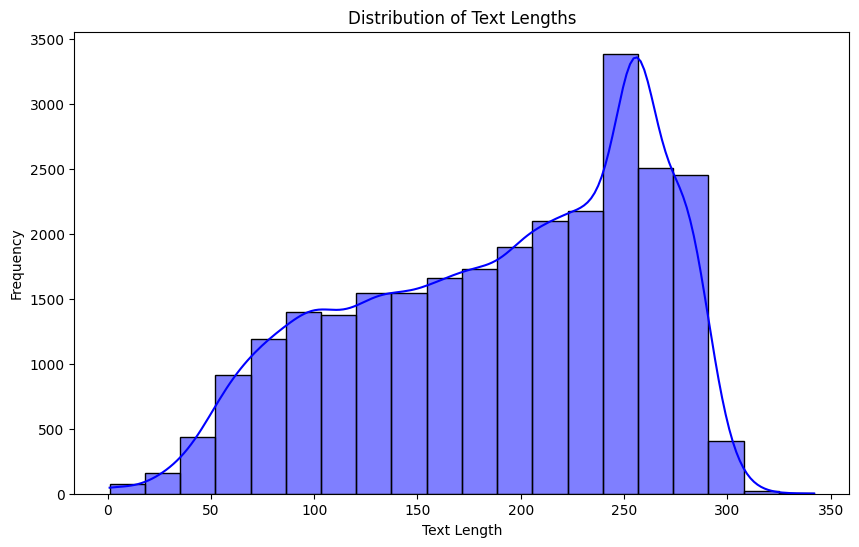

In [62]:
## Use for max_sequence length
X_train_df['length'] = X_train_df['text'].str.len()

# Plot the distribution of text lengths using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(X_train_df['length'], bins=20, kde=True, color='blue')  # KDE adds a smooth curve
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Text Vectorization Layer

In [63]:
vocab_size = 5000 # 5,000 to 50,000
max_features = vocab_size # size of vocabulary


token_df = pd.DataFrame()
token_df['token_lengths'] = token_lengths
token_df['token_lengths'].max()

max_sequence_length = len(max(X_train, key=len)) # max length of a review, equal to longest review in the training dataset
sequence_length = 250


vectorize_layer = layers.TextVectorization(
    standardize=None,
    max_tokens=max_features + 2, # to take into account the [oov] and [pad] tokens
    output_mode='int',
    output_sequence_length=sequence_length)

Convert to Tensors

In [64]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
X_val = tf.convert_to_tensor(X_val)

y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)
y_val = tf.convert_to_tensor(y_val)

Adapt vocabulary on training set

In [65]:
vectorize_layer.adapt(X_train)
vocab = vectorize_layer.get_vocabulary()

# Modeling

## LSTM

In [70]:
embedding_dim = 128

# can add class weights if necessary

LSTM_Model = tf.keras.Sequential([
  vectorize_layer,
  tf.keras.layers.Embedding(input_dim=max_features + 2, output_dim=embedding_dim, input_length=sequence_length), # mask_zero=True if masking [PAD], ensure [PAD] is set to the value 0
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
  tf.keras.layers.Dense(3, activation='softmax') # equal to number of labels
  ])

LSTM_Model.summary()

LSTM_Model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

##Increase epochs to improve accuracy/training
Hist = LSTM_Model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
843/843 ━━━━━━━━━━━━━━━━━━━━ 426s 492ms/step - accuracy: 0.5358 - loss: 0.9141 - val_accuracy: 0.7430 - val_loss: 0.6352
Epoch 2/3
843/843 ━━━━━━━━━━━━━━━━━━━━ 438s 487ms/step - accuracy: 0.7996 - loss: 0.5395 - val_accuracy: 0.7701 - val_loss: 0.5940
Epoch 3/3
843/843 ━━━━━━━━━━━━━━━━━━━━ 453s 500ms/step - accuracy: 0.8309 - loss: 0.4608 - val_accuracy: 0.7736 - val_loss: 0.5969


If Underfitting, increase complexity
* Add layers
* Add units in layers
* Switch activation functions if it seems like vanishing/exploding gradient
* Add masking layer so that [PAD] tokens are skipped in the learning process

If Overfitting, decrease complexity
* Remove layers
* Reduce units in layers
* Add dropout layers
* Add regularization

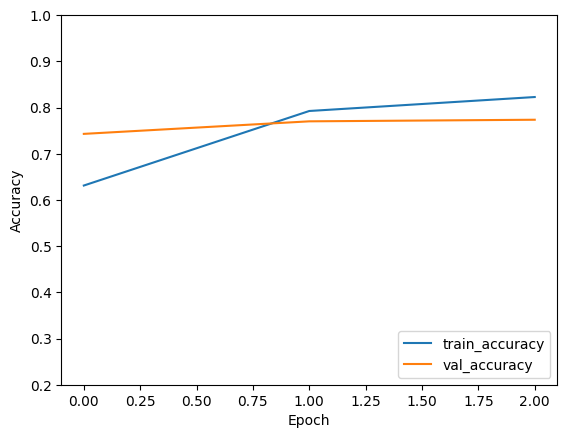

In [71]:
# train accuracy and val accuracy 
plt.plot(Hist.history['accuracy'], label='train_accuracy')
plt.plot(Hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

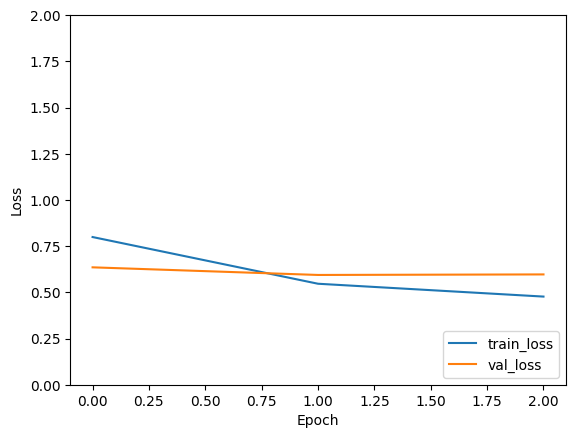

In [72]:
# train loss and val loss
plt.plot(Hist.history['loss'], label='train_loss')
plt.plot(Hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

In [15]:
embedding_dim = 64

# can add class weights if necessary

LSTM_Model = tf.keras.Sequential([
  vectorize_layer,
  tf.keras.layers.Embedding(input_dim=max_features + 2, output_dim=embedding_dim, input_length=sequence_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
  tf.keras.layers.Dense(3, activation='softmax') # equal to number of labels
  ])

LSTM_Model.summary()

LSTM_Model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

##Increase epochs to improve accuracy/training
Hist = LSTM_Model.fit(train_tweets, train_labels, epochs=10, validation_data=(val_tweets, val_labels))


c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 246s 208ms/step - accuracy: 0.5372 - loss: 0.9276 - val_accuracy: 0.7538 - val_loss: 0.6167
Epoch 2/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 266s 212ms/step - accuracy: 0.7886 - loss: 0.5839 - val_accuracy: 0.7736 - val_loss: 0.5696
Epoch 3/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 259s 231ms/step - accuracy: 0.8151 - loss: 0.5129 - val_accuracy: 0.7691 - val_loss: 0.5811
Epoch 4/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 234s 208ms/step - accuracy: 0.8315 - loss: 0.4739 - val_accuracy: 0.7676 - val_loss: 0.5871
Epoch 5/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 270s 215ms/step - accuracy: 0.8430 - loss: 0.4267 - val_accuracy: 0.7696 - val_loss: 0.6229
Epoch 6/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 339s 283ms/step - accuracy: 0.8570 - loss: 0.3884 - val_accuracy: 0.7684 - val_loss: 0.6791
Epoch 7/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 263s 231ms/step - accuracy: 0.8703 - loss: 0.3495 - val_accuracy: 0.7609 - val_loss: 0.7475
Epoch 8/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 324s 285ms/step - ac

## Get Accuracy on Test Set

* Check performance on individual labels if there is a label imbalance, add class weights if necessary, or random undersampling

In [73]:
# Step 1: Make predictions on the test set
y_pred_probs = LSTM_Model.predict(X_test)

# Step 2: Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Print the first few predictions (optional)
print("Predicted classes:", y_pred[:10])
print("True classes:", y_test[:10])

# Step 4: Evaluate the model's performance (optional)
# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 5: Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

281/281 ━━━━━━━━━━━━━━━━━━━━ 45s 154ms/step
Predicted classes: [0 2 0 1 1 1 0 0 1 1]
True classes: tf.Tensor([0 2 1 1 1 1 0 0 2 1], shape=(10,), dtype=int64)
Test Accuracy: 0.7680
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      3918
           1       0.79      0.75      0.77      3406
           2       0.66      0.70      0.68      1667

    accuracy                           0.77      8991
   macro avg       0.75      0.76      0.75      8991
weighted avg       0.77      0.77      0.77      8991



[[3160  422  336]
 [ 566 2570  270]
 [ 228  264 1175]]


[Text(0, 0.5, '0: Positive'),
 Text(0, 1.5, '1: Negative'),
 Text(0, 2.5, '2: Neutral')]

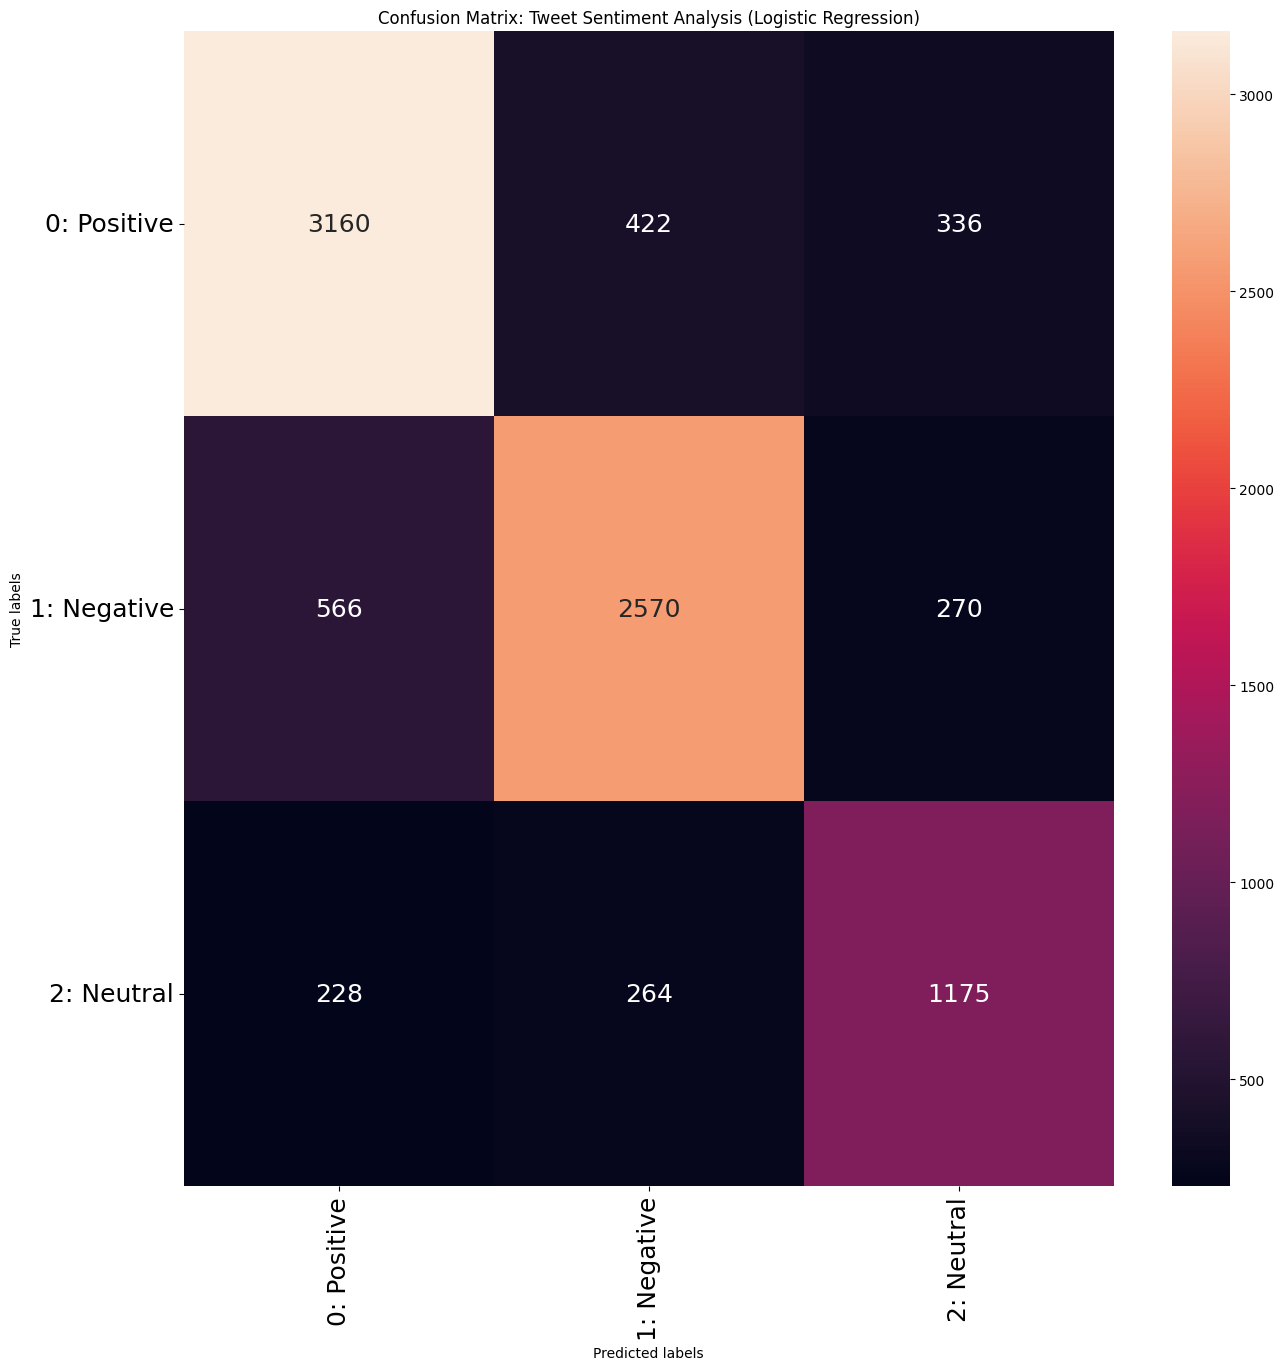

In [74]:
CM=confusion_matrix(y_pred=y_pred, y_true=y_test)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (Logistic Regression)') 
ax.xaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=0, fontsize = 18)